In this notebook, we:
- Further expand the input feature space using histograms of oriented gradients.
- Shift towards fancier training regimes (i.e. we use an adaptive learning rate).

### Import the libraries

In [12]:
from os import environ
environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Deactive warnings about building tf from source

from scipy.misc import imread, imresize
from datetime import datetime
from os.path import exists
from shutil import rmtree
from os import makedirs
import tensorflow as tf
from glob import glob
import numpy as np

from models import two_layer_convnet_with_batch_normalization
from pymvtest import classification

from skimage.filters import sobel_h, sobel_v
from skimage.filters import gabor_kernel
from scipy.signal import convolve
from skimage.feature import hog

import matplotlib.pyplot as plt
%matplotlib inline

### Define a master dictionary

In [5]:
TF = {
      'batch_size':32,
      'graph':None,
      'image_size':200,
      'patch_size':20,
      'input_channels':2,
      'learning_rate':0.001,
      'n_classes':2,
      'output_channels':[8, 4, 5],
      'filter_size':[3, 5],
      'seed':3,
      'split_fraction':0.7,
      'summary_train':[],
      'summary_test':[],
      'training_steps':501,
      'test_id':'003_Batch_normalized',
}

### Import the data

In [6]:
print('Importing data...')

# Whiten on import
images = np.array([np.expand_dims(imread(fp), axis = -1)
                  for fp in glob('./data/resized-images/*.png')])
masks  = np.array([imread(fp)/255 for fp in glob('./data/masked-images/*.png')])

print('Data imported.')

Importing data...
Data imported.


### Provide an example HOG

What's a HOG?
1. Compute pixel intensity gradients (magnitudes and directions).
2. Define cells - sets of adjacent pixels (e.g. in a 40x40 square).
3. Define a histogram with bins corresponding to orientations (e.g. $-\pi, 0, \pi, 2\pi$).
4. Pool cell gradients in bins according magnitude (i.e. big gradient $\implies$ big bin vote).
5. Normalize histogram bin magnitudes over adjacent cells (i.e. average histogram cumulative counts, normalize cells by result).

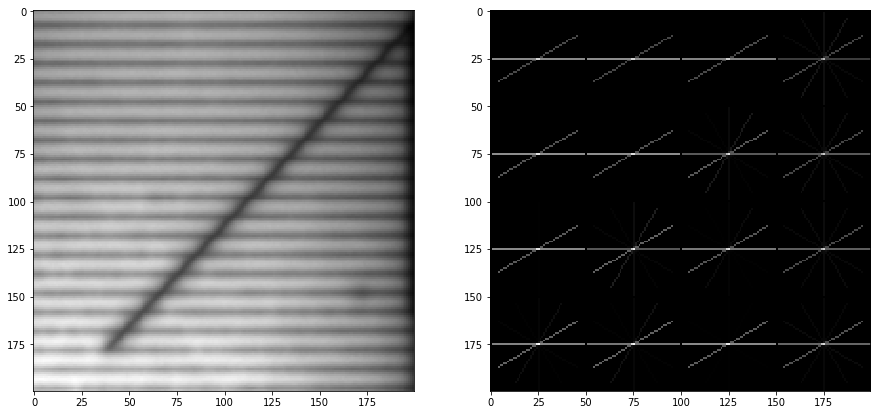

In [47]:
from skimage.feature import hog

_, hi = hog(images[30, :, :, 0], orientations=6, pixels_per_cell=(50, 50),
            cells_per_block=(1, 1), visualise=True, block_norm='L2-Hys')

f, axs = plt.subplots(1, 2, figsize = (15, 7))
axs[0].imshow(images[30, 400:600, 400:600, 0], cmap = 'gray')
axs[1].imshow(hi[400:600, 400:600], cmap = 'gray');

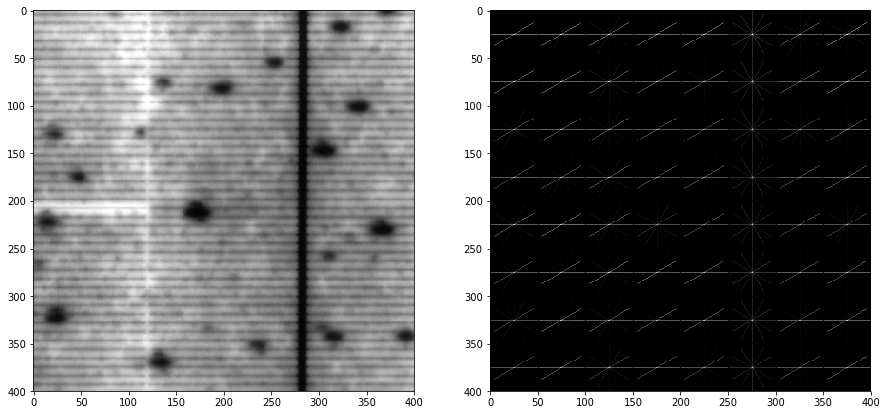

In [48]:
k = 11
fd, hog_image = hog(images[k, :, :, 0], orientations=6, pixels_per_cell=(50, 50),
                        cells_per_block=(1, 1), visualise=True, block_norm='L2-Hys')

f, axs = plt.subplots(1, 2, figsize = (15, 7))
axs[0].imshow(images[k, 200:600, 200:600, 0], cmap = 'gray')
axs[1].imshow(hog_image[200:600, 200:600], cmap = 'gray');

$965 \times 965$ images, $50 \times 50$ cells, $6$ bins per cell

$\implies \left \lfloor{\frac{965}{50}} \right \rfloor^2 \cdot 6 = 2166$ bins per image.

Now, we have several options for how to include this in our network. We could:
- Take a vector of the bin counts and pass it into the network at the fully-connected layer.


- Shape the bins into a $19 \times 19 \times 6$ tensor - where the indices $i, j, k$ correspond to the vertical cell position, the horizontal position, and the orientation respectively - then train another convolutional neural network against the result.
    - Once this secondary network has been trained, connect its output (sans linear classifier) to the fully-connected layer of our main network.
    - Key benefit of this method: spatial invariance.
    
    
- Project the histogram tensor onto a space of the same dimensionality as the input image. This obtains spatial invariance without the need to train one network and plug it in to another network.

### Define a HOGs function

In [94]:
def HOG_filter(image):
    PX_PER_CELL    = 50
    N_ORIENTATIONS = 6
    hog_feature    = hog(images[k, :, :, 0], orientations=N_ORIENTATIONS,
                         pixels_per_cell=(PX_PER_CELL, PX_PER_CELL),
                         cells_per_block=(1, 1), visualise=False, block_norm='L2-Hys')
    n_bins         = image.shape[0]//PX_PER_CELL
    hog_tensor     = (hog_feature.reshape([n_bins, n_bins, N_ORIENTATIONS])).T
    proj_matrix    = np.eye(image.shape[0])
    proj_matrix    = proj_matrix[:, :n_bins]
    hog_tensor     = np.matmul(np.matmul(proj_matrix, hog_tensor), proj_matrix.T)
    return hog_tensor

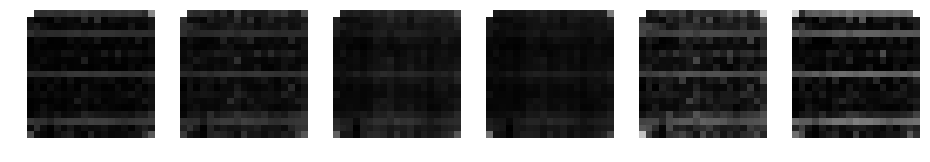

In [115]:
example = HOG_filter(images[30, :, :, 0])
f, axs = plt.subplots(1, 6, figsize = (16, 3))
for i, ax in enumerate(axs):
    ax.imshow(example[i, :19, :19], cmap = 'gray');
    ax.axis('off');
    
# NEED TO CHECK RESHAPE ORDER

### Filter and resize the data

In [ ]:
def Sobel_and_Gabor_filter(image):
    if len(image.shape) == 3: image = image.squeeze()
    K = gabor_kernel(frequency = 0.05, theta = np.pi/4, bandwidth = 2)
    image = sobel_h(image)
    image = sobel_v(image)
    re_l = np.real(convolve(image, K, mode = 'same'))
    re_r = np.real(convolve(image, np.flip(K, axis=0), mode = 'same'))
    image   = re_l - re_r
    return np.expand_dims(image, axis = -1)

print('Filtering, stacking, whitening, resizing and splitting images...')
# Filter the images
images = np.array([np.concatenate([img, _filter(img)], axis = 2) for img in images])

# Whiten the images
eps = 1e-6
white_images = (images - np.mean(images, axis = 0))/(np.std(images, axis = 0)+eps)

# Resize the images
images, masks = classification.resize(white_images, masks, TF['image_size'])

# Extract three images for testing, use the test for training/validation
query_ix      = np.array([(i == 4 or i == 14 or i == 38) for i in range(0, images.shape[0])])
train_ix      = np.logical_not(query_ix)
query_images  = images[query_ix, :, :, :]
query_masks   = masks[query_ix, :, :]
images        = images[train_ix, :, :, :]
masks         = masks[train_ix, :, :]

print('Images filtered, stacked, whitened, resized, and split.')

### Train the batch-normalized model

In [ ]:
# Get the graph
batch_normalized_TF     = two_layer_convnet_with_batch_normalization.model(TF)

# Fit the model
batch_normalized_tester = classification.Tester(images, masks, batch_normalized_TF)
batch_normalized_tester.fit_model()

### Train a model to the same spec., without batch normalization

In [ ]:
non_normalized_TF = {
      'batch_size':32,
      'graph':None,
      'image_size':200,
      'patch_size':20,
      'input_channels':2,
      'learning_rate':0.001,
      'n_classes':2,
      'output_channels':[8, 4, 5],
      'filter_size':[3, 5],
      'seed':3,
      'split_fraction':0.7,
      'summary_train':[],
      'summary_test':[],
      'training_steps':501,
      'test_id':'003_Not_batch_normalized',
}
non_normalized_TF = two_layer_convnet.model(non_normalized_TF)
tester_non_normalized = classification.Tester(images, masks, non_normalized_TF)
tester_non_normalized.fit_model()

### Evaluate query performance

##### Query images

In [ ]:
f, axs = plt.subplots(1, 3, figsize = (15, 5))
for i, ax in enumerate(axs):
    ax.imshow(query_images[i, :, :, 0], cmap = 'gray')
    ax.axis('off');

##### Predictions with batch normalization

In [ ]:
bn_predictions, query_masks = batch_normalized_tester.query_model(query_images, query_masks)

f, axs = plt.subplots(1, 3, figsize = (15, 5))
for i, ax in enumerate(axs):
    ax.imshow(bn_predictions[i, :, :], cmap = 'gray')
    ax.axis('off');

##### Predictions without batch normalization

In [ ]:
nobn_predictions, query_masks = tester_non_normalized.query_model(query_images, query_masks)

f, axs = plt.subplots(1, 3, figsize = (15, 5))
for i, ax in enumerate(axs):
    ax.imshow(nobn_predictions[i, :, :], cmap = 'gray')
    ax.axis('off');